<h1 style="text-align: center;">CS 6476 - Computer Vision </h1>
<h2 style="text-align: center;">Problem Set 3 - Geometry</h2>

In [120]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import copy as cp
import sys
import random
from PIL import Image

### 1 Calibration :

In [121]:
def load_data(D3_pts_path,D2_pts_path):
    D3_pts = []
    D2_pts = []
    with open(D3_pts_path) as D3_file:
        line = D3_file.read()
        D3_data = line.split('\n')
        
        for pt in D3_data : 
            pt = pt.split(' ')
            pt = [float(x) for x in pt if x!='']
            if(pt != []):
                D3_pts.append(pt)

    D3_file.closed
    with open(D2_pts_path) as D2_file:
        line = D2_file.read()
        D2_data = line.split('\n')
        for pt in D2_data : 
            pt = pt.split(' ')
            pt = [float(x) for x in pt if x!='' and x!=' ']
            if(pt != []):
                D2_pts.append(pt)
    D2_file.closed
    return np.array(D3_pts),np.array(D2_pts)
    
    
def buildSysMat(d2_pts,d3_pts):    
    nb_pts = len(d2_pts)
    A = np.zeros((2*nb_pts,11))
    b = np.zeros(2*nb_pts, dtype=np.float32)
    X = d3_pts[:,0]
    Y = d3_pts[:,1]
    Z = d3_pts[:,2]
    u = d2_pts[:,0]
    v = d2_pts[:,1]
    A[::2,:] = np.column_stack((X,Y,Z,np.ones(nb_pts),np.zeros(nb_pts),np.zeros(nb_pts),np.zeros(nb_pts),np.zeros(nb_pts)
                                ,-u*X,-u*Y,-u*Z))
    A[1::2,:] = np.column_stack((np.zeros(nb_pts),np.zeros(nb_pts),np.zeros(nb_pts),np.zeros(nb_pts),X,Y,Z,np.ones(nb_pts)
                                 ,-v*X,-v*Y,-v*Z))
    b[::2]=u
    b[1::2]=v
    return A,b

def leastSqCal(D3_pts, D2_pts):
    M = np.zeros((3,4))
    
    A,b = buildSysMat(D2_pts,D3_pts)
#     b = np.zeros(2*len(D2_pts), dtype=np.float32)
#     b[::2] = D2_pts[:][0]
#     b[1::2] = D2_pts[:][1]
    M,resid,_,_ = np.linalg.lstsq(A, b,rcond=None)
    M = np.append(M, 1)
    M = M.reshape((3,4))
#     u,s,vt = np.linalg.svd(A,full_matrices=True)
#     k = 0
#     for i in np.arange(3):
#         for j in np.arange(4):
#             M[i,j] = vt[-1,k]
#             k += 1

    return M,resid

def proj(pt,M):

    pt = np.append(pt,1)
    projPt = np.dot(M,pt)
    projPt = projPt[:2]/projPt[2]
    return projPt
    

#### 1.1

In [122]:
d3_pts, d2_pts = load_data('./pts3d-norm.txt','./pts2d-norm-pic_a.txt')

M,resid = leastSqCal(d3_pts,d2_pts)
print('M matrix :\n',M)

print('residual : ',resid[0])
pt3D = d3_pts[-1] 
print('coordinates of the last point : ',pt3D)
pt2D = proj(pt3D,M)
print('projection coordinates of the last point : ',pt2D)


M matrix :
 [[ 0.76785833 -0.49384797 -0.02339783  0.00674444]
 [-0.08521339 -0.09146819 -0.9065233  -0.08775678]
 [ 0.18265015  0.29882918 -0.07419243  1.        ]]
residual :  0.0001309404067940437
coordinates of the last point :  [1.2323 1.4421 0.4506]
projection coordinates of the last point :  [ 0.14190585 -0.45183984]


#### 1.2

In [123]:
d2_pts,d3_pts = load_data('./pts2d-pic_b.txt','./pts3d.txt') 



In [124]:
def residual(pts_3D,pts_2D,M):
    l_proj = np.array([proj(pt,M) for pt in pts_3D])
#     print(l_proj)
    res = np.linalg.norm(l_proj-pts_2D)
    return res
    
    
def calibrate(k,pts_2d,pts_3d):
    resid = sys.maxsize
    M = np.zeros((3,4))
    pts_d2_cp = cp.deepcopy(pts_2d)
    pts_d3_cp = cp.deepcopy(pts_3d)
    for l in np.arange(10):
        num_data = len(pts_d2_cp)
        indexes = np.arange(num_data)
        random.shuffle(indexes)
        pts_2d = [pts_d2_cp[i] for i in indexes]
        pts_3d = [pts_d3_cp[i] for i in indexes]
    
        pts_2d = np.array(pts_2d)
        pts_3d = np.array(pts_3d)
        calc_2d = pts_2d[:k]
        calc_3d = pts_3d[:k]
        test_2d = pts_2d[-5:-1]
        test_3d = pts_3d[-5:-1]
        
        tempM,_ = leastSqCal(calc_3d,calc_2d)
#         print(tempM)
        tempResid = residual(test_3d,test_2d,tempM)
        if(tempResid < resid):
            M = tempM
            resid = tempResid
    return M,resid
    
       

In [125]:

# k = 8
M_8,res_8= calibrate(8,d2_pts,d3_pts)
print('M for k = 8 :\n',M_8)
print('residual for k = 8 : ',res_8)
# k = 12
M_12,res_12 = calibrate(12,d2_pts,d3_pts)
print('\nM for k = 12 :\n',M_12)
print('residual for k = 12 : ',res_12)

# k = 16
M_16,res_16 = calibrate(16,d2_pts,d3_pts)
print('\nM for k = 16 :\n',M_16)
print('residual for k = 16 : ',res_16)


M for k = 8 :
 [[-2.02908657e+00  1.14612892e+00  4.60239870e-01  2.49085715e+02]
 [-4.52133899e-01 -3.12850305e-01  2.16410331e+00  1.67366959e+02]
 [-2.22583049e-03 -1.12309236e-03  6.51246491e-04  1.00000000e+00]]
residual for k = 8 :  2.416568488890742

M for k = 12 :
 [[-2.05461792e+00  1.21149359e+00  3.75011685e-01  2.39097655e+02]
 [-4.57415427e-01 -2.97926643e-01  2.15574078e+00  1.64540284e+02]
 [-2.25554021e-03 -1.08368068e-03  5.40481764e-04  1.00000000e+00]]
residual for k = 12 :  1.5455145248930409

M for k = 16 :
 [[-2.04591636e+00  1.18661364e+00  3.88224333e-01  2.43791705e+02]
 [-4.56523950e-01 -3.02477336e-01  2.14539465e+00  1.66017636e+02]
 [-2.24460380e-03 -1.09563775e-03  5.54994163e-04  1.00000000e+00]]
residual for k = 16 :  1.4096557586859246


#### 1.3

In [126]:
def findCenter(M):
    m4 = M[:,3]
    Q = M[:,:3]
    Q_inv = np.linalg.pinv(Q)
    return -np.dot(Q_inv,m4)

In [127]:
print('location of the camera center:\n',findCenter(M_16))

location of the camera center:
 [303.09428241 307.17945024  30.42190149]


### 2 Fundamental Matrix Estimation :

In [128]:
pts_a,pts_b = load_data('pts2d-pic_a.txt','pts2d-pic_b.txt') 

In [129]:
def buildSysF(pts_a,pts_b):
    u_a = pts_a[:,0]
    v_a = pts_a[:,1]
    u_b = pts_b[:,0]
    v_b = pts_b[:,1]
    # A*col(Fij) = (u_a*u_b,v_a*u_b,u_b,u_a*v_b,v_a*v_b,v_b,u_a,v_a)*col(Fij)=1
    A = np.column_stack((u_a*u_b, v_a*u_b, u_b, u_a*v_b, v_a*v_b, v_b, u_a, v_a))
    nb_pts = len(u_a)
    b = -np.ones(nb_pts)
    return A,b
    
def sysCalcLstSq(pts_a,pts_b):
    A,b = buildSysF(pts_a,pts_b)
    F,res,_,_ = np.linalg.lstsq(A,b,rcond=None)
    F = np.append(F,1)
    F = F.reshape((3,3))
    return F,res

In [130]:
F,res = sysCalcLstSq(pts_a,pts_b)
print('f tild :',F)
print(F.shape)

f tild : [[-6.60675944e-07  7.90642197e-06 -1.88480992e-03]
 [ 8.82674944e-06  1.21863596e-06  1.72276843e-02]
 [-9.08539064e-04 -2.64201801e-02  1.00000000e+00]]
(3, 3)


In [131]:
def funda(pts_a,pts_b):
    F,_ = sysCalcLstSq(pts_a,pts_b)
    u,s,vt = np.linalg.svd(F,full_matrices=True)
#     print(s)
    s[2] = 0
    F = np.dot(u,np.dot(np.diag(s),vt))
    return F
    

In [132]:
F = funda(pts_a,pts_b)
print('fundamental matrix :\n',F)

fundamental matrix :
 [[-5.35883058e-07  7.89972529e-06 -1.88480998e-03]
 [ 8.83820595e-06  1.21802118e-06  1.72276843e-02]
 [-9.08539027e-04 -2.64201801e-02  1.00000000e+00]]


In [133]:
def drawLines(F,imb,pts_2d_a):
    height_l,width_l,_ = imb.shape
    nb_pts = len(pts_2d_a)
    
    Pul = np.array([0,0,1])
    Pbl = np.array([height_l-1,0,1])
    lL = np.cross(Pul,Pbl)
    
    Pur = np.array([0,width_l,1])
    Pbr = np.array([height_l-1,width_l,1])
    lR = np.cross(Pur,Pbr)
    
    for pt in pts_2d_a:
        pt = np.append(pt,1)
        lb = np.dot(F,pt)
        Pl = np.cross(lb,lL)
        Pr = np.cross(lb,lR)
        Pl = (Pl[:2]/Pl[2]).astype(int)
        Pr = (Pr[:2]/Pr[2]).astype(int)
        cv2.line(imb,tuple(Pl),tuple(Pr),(0,255,0))
    
    return imb
    

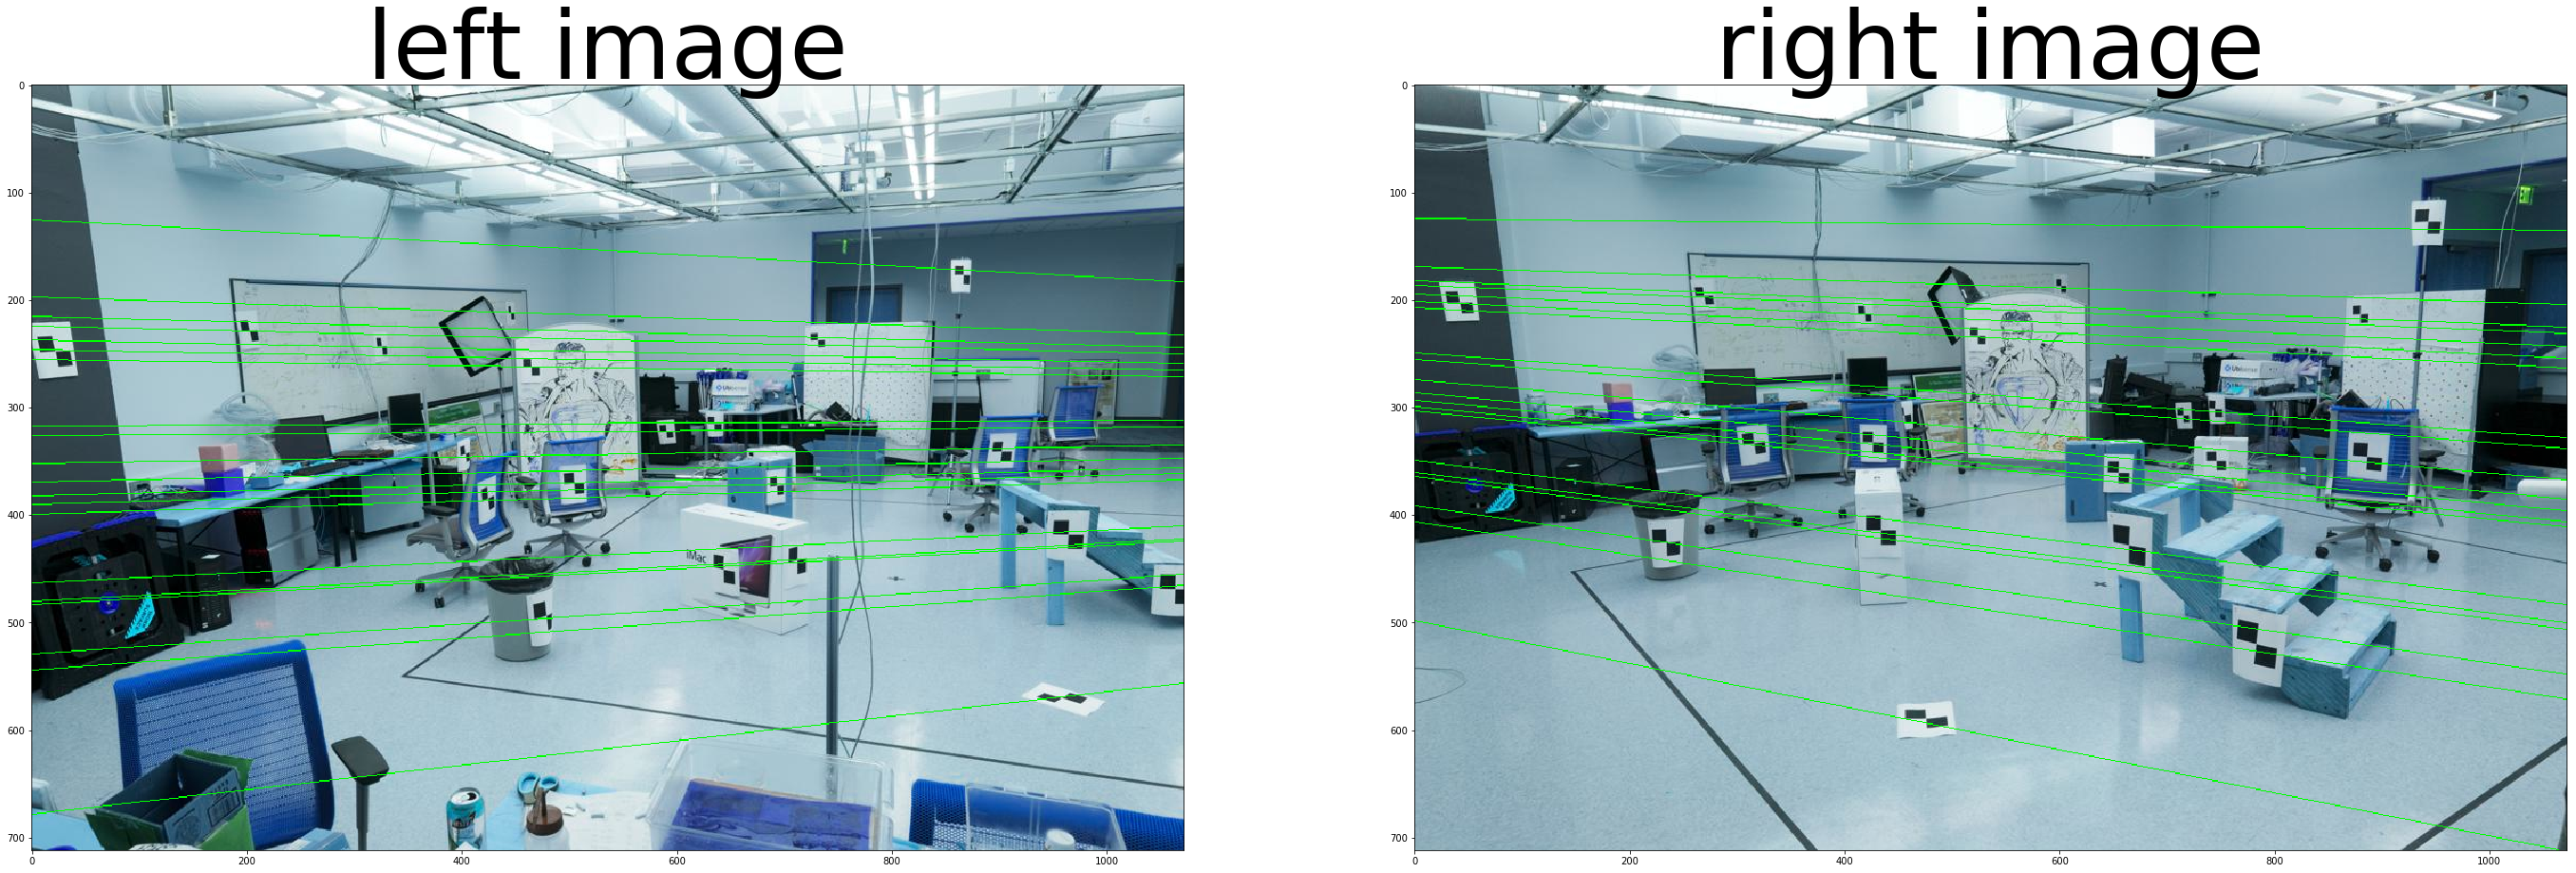

In [134]:
im = cv2.imread('pic_b.jpg')
im2 = cv2.imread('pic_a.jpg')
# print(pts_a)

imb = drawLines(F,im,pts_a)
ima = drawLines(F.transpose(),im2,pts_b)
plt.figure(figsize=(100,100))
plt.subplot(1,4,1),plt.imshow(imb),plt.title('left image',fontsize=100)
plt.subplot(1,4,2),plt.imshow(ima),plt.title('right image',fontsize=100)

plt.show()

In [141]:
cv2.imwrite('ps3-2-a.jpg',imb)
cv2.imwrite('ps3-2-b.jpg',ima)


True

### Extra Credit

In [ ]:
def T(pts):
    m=np.mean(pts,axis=0)
#     print(m)
    pts_tp = [i-m for i in pts]
#     print(pts_tp)
    s = 1/np.abs(np.std(pts_tp,axis=0)).max()
    S = np.diag([s,s,1])
    C = np.diag([1,1,1])
    C[0,2] = -m[0]
    C[1,2] = -m[1]
    T = np.dot(S,C)
    return T

In [ ]:
T_a = T(pts_a)
T_b = T(pts_b)
print('Ta = \n',T_a)
print('Tb = \n',T_b)

In [ ]:
pts_a_h = np.array([np.append(pt,1) for pt in pts_a])
pts_a_n = np.dot(pts_a_h,T_a)
pts_b_h = np.array([np.append(pt,1) for pt in pts_b])
pts_b_n = np.dot(pts_b_h,T_b)
F_tild = funda(pts_a_n,pts_b_n)
print(F_tild)

In [ ]:
F = np.dot(np.transpose(T_b),np.dot(F_tild,T_a))


In [ ]:
pts_a,pts_b = load_data('pts2d-pic_a.txt','pts2d-pic_b.txt') 
im = cv2.imread('pic_b.jpg')
im2 = cv2.imread('pic_a.jpg')
# print(pts_a)

imb = drawLines(F,im,pts_a)
ima = drawLines(F.transpose(),im2,pts_b)
plt.figure(figsize=(100,100))
plt.subplot(1,4,1),plt.imshow(imb),plt.title('left image',fontsize=100)
plt.subplot(1,4,2),plt.imshow(ima),plt.title('right image',fontsize=100)

plt.show()